# CC3501 - Aux 7: Método de Diferencias Finitas

#### **Profesor: Daniel Calderón**
#### **Auxiliares: Diego Donoso y Pablo Pizarro**
#### **Ayudantes: Francisco Muñoz, Matías Rojas y Sebastián Contreras**
##### Fecha: 31/05/2019
---
#### Objetivos:
*	Ejercitar el método de diferencias finitas en una aplicación práctica
*   Aprender a escribir ecuaciones en un sistema lineal y a resolverlo con numpy
*	Visualizar la solución utilizando matplotlib/mayavi

[Markdowns for Jupyter Notebooks](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)

_Cuando te enteras de que puedes poner gifs en Notebooks_

In [1]:
from IPython.display import HTML
HTML('<center><img src="https://media.giphy.com/media/2xRWvsvjyrO2k/giphy.gif"></center>')

#### Problemas

1. Estudie el ejemplo ex_finite_differences.py. La figura ex_finite_differences.png es complementaria a dicha solución.

_Nota: Se usa comando %load filename para cargar archivo en notebook_

30 39


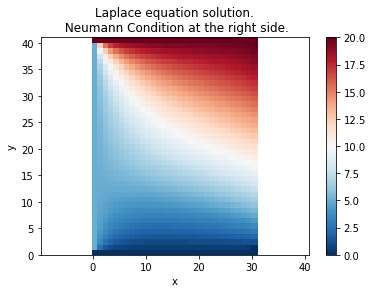

In [2]:
# %load ex_finite_differences_laplace_neumann.py
%matplotlib inline
"""
Daniel Calderon, CC3501, 2019-1
Finite Differences for Partial Differential Equations

Solving the Laplace equation in 2D with Dirichlet and
Neumann border conditions over a square domain.
"""

import numpy as np
import matplotlib.pyplot as mpl

# Problem setup
H = 4
W = 3
F = 2
h = 0.1

# Boundary Dirichlet Conditions:
TOP = 20
BOTTOM = 0
LEFT = 5
RIGHT = 15

# Number of unknowns
# left, bottom and top sides are known (Dirichlet condition)
# right side is unknown (Neumann condition)
nh = int(W / h)
nv = int(H / h) - 1

print(nh, nv)

# In this case, the domain is just a rectangle
N = nh * nv

# We define a function to convert the indices from i,j to k and viceversa
# i,j indexes the discrete domain in 2D.
# k parametrize those i,j, this way we can tidy the unknowns
# in a column vector and use the standard algebra

def getK(i,j):
    return j * nh + i

def getIJ(k):
    i = k % nh
    j = k // nh
    return (i, j)

"""
# This code is useful to debug the indexation functions above
print("="*10)
print(getK(0,0), getIJ(0))
print(getK(1,0), getIJ(1))
print(getK(0,1), getIJ(2))
print(getK(1,1), getIJ(3))
print("="*10)

import sys
sys.exit(0)
"""

# In this matrix we will write all the coefficients of the unknowns
A = np.zeros((N,N))

# In this vector we will write all the right side of the equations
b = np.zeros((N,))

# Note: To write an equation is equivalent to write a row in the matrix system

# We iterate over each point inside the domain
# Each point has an equation associated
# The equation is different depending on the point location inside the domain
for i in range(0, nh):
    for j in range(0, nv):

        # We will write the equation associated with row k
        k = getK(i,j)

        # We obtain indices of the other coefficients
        k_up = getK(i, j+1)
        k_down = getK(i, j-1)
        k_left = getK(i-1, j)
        k_right = getK(i+1, j)

        # Depending on the location of the point, the equation is different
        # Interior
        if 1 <= i and i <= nh - 2 and 1 <= j and j <= nv - 2:
            A[k, k_up] = 1
            A[k, k_down] = 1
            A[k, k_left] = 1
            A[k, k_right] = 1
            A[k, k] = -4
            b[k] = 0
        
        # left side
        elif i == 0 and 1 <= j and j <= nv - 2:
            A[k, k_up] = 1
            A[k, k_down] = 1
            A[k, k_right] = 1
            A[k, k] = -4
            b[k] = -LEFT
        
        # right side
        elif i == nh - 1 and 1 <= j and j <= nv - 2:
            A[k, k_up] = 1
            A[k, k_down] = 1
            A[k, k_left] = 2
            A[k, k] = -4
            b[k] = -2 * h * F
        
        # bottom side
        elif 1 <= i and i <= nh - 2 and j == 0:
            A[k, k_up] = 1
            A[k, k_left] = 1
            A[k, k_right] = 1
            A[k, k] = -4
            b[k] = -BOTTOM
        
        # top side
        elif 1 <= i and i <= nh - 2 and j == nv - 1:
            A[k, k_down] = 1
            A[k, k_left] = 1
            A[k, k_right] = 1
            A[k, k] = -4
            b[k] = -TOP

        # corner lower left
        elif (i, j) == (0, 0):
            A[k, k] = 1
            b[k] = (BOTTOM + LEFT) / 2

        # corner lower right
        elif (i, j) == (nh - 1, 0):
            A[k, k] = 1
            b[k] = BOTTOM

        # corner upper left
        elif (i, j) == (0, nv - 1):
            A[k, k] = 1
            b[k] = (TOP + LEFT) / 2

        # corner upper right
        elif (i, j) == (nh - 1, nv - 1):
            A[k, k] = 1
            b[k] = TOP

        else:
            print("Point (" + str(i) + ", " + str(j) + ") missed!")
            print("Associated point index is " + str(k))
            raise Exception()


# A quick view of a sparse matrix
#mpl.spy(A)

# Solving our system
x = np.linalg.solve(A, b)

# Now we return our solution to the 2d discrete domain
# In this matrix we will store the solution in the 2d domain
u = np.zeros((nh,nv))

for k in range(0, N):
    i,j = getIJ(k)
    u[i,j] = x[k]

# Adding the borders, as they have known values
ub = np.zeros((nh + 1, nv + 2))
ub[1:nh + 1, 1:nv + 1] = u[:,:]

# Dirichlet boundary condition
# top 
ub[0:nh + 2, nv + 1] = TOP
# bottom 
ub[0:nh + 2, 0] = BOTTOM
# left
ub[0, 1:nv + 1] = LEFT

# this visualization locates the (0,0) at the lower left corner
# given all the references used in this example.
fig, ax = mpl.subplots(1,1)
pcm = ax.pcolormesh(ub.T, cmap='RdBu_r')
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Laplace equation solution.\n Neumann Condition at the right side.')
ax.set_aspect('equal', 'datalim')

# Note:
# imshow is also valid but it uses another coordinate system,
# a data transformation is required
#ax.imshow(ub.T)
mpl.show()

30 39


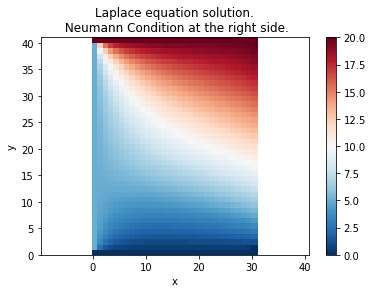

In [3]:
%run ex_finite_differences_laplace_neumann.py

30 39


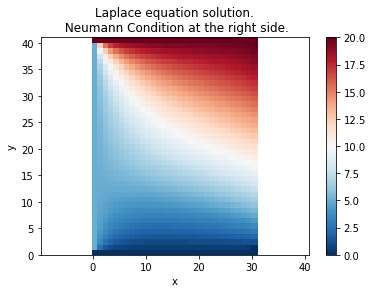

61


In [4]:
from ex_finite_differences_laplace_neumann import *

print(getK(1, 2))

2. Añada gráficos para visualizar la solución como:

    1. Superficie
    2. Curvas de nivel


> Utilice distintas paletas de colores y rotule correctamente cada eje.

  _Hint: Guía de Laplace-Dirichlet o revisar los links_
  
  _[Link](https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html)_
  
  [Link](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.contour.html)


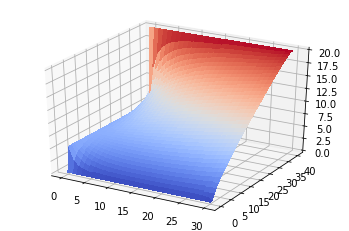

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, nh + 1, 1)
Y = np.arange(0, nv + 2, 1)
X, Y = np.meshgrid(X, Y)
Z = ub.T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Text(0, 0.5, 'y')

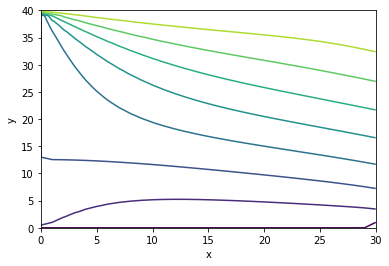

In [4]:
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')

3.	Modifique el programa para que resuelva el sistema utilizando h = 0.5, 0.1, 0.05. Adjunte gráficos de todas sus soluciones.

_Nota: Para espaciados más pequeños se hace necesario utilizar otra forma para guardar las matrices, de ahí sale sparse_

_Nota 2: Con h= 0.01 se cae (probablemente)_

In [7]:
def problem(h_p):
    # Problem setup
    H = 4
    W = 3
    F = 2

    # Boundary Dirichlet Conditions:
    TOP = 20
    BOTTOM = 0
    LEFT = 5
    RIGHT = 15

    # Number of unknowns
    # left, bottom and top sides are known (Dirichlet condition)
    # right side is unknown (Neumann condition)
    nh_p = int(W / h_p) - 1
    nv_p = int(H / h_p) - 1

    print(nh_p, nv_p)

    # In this case, the domain is just a rectangle
    N_p = nh_p * nv_p


    # We define a function to convert the indices from i,j to k and viceversa
    # i,j indexes the discrete domain in 2D.
    # k parametrize those i,j, this way we can tidy the unknowns
    # in a column vector and use the standard algebra

    def newgetK(i, j):
        return j * nh_p + i


    def newgetIJ(k):
        i = k % nh_p
        j = k // nh_p
        return (i, j)


    """
    # This code is useful to debug the indexation functions above
    print("="*10)
    print(getK(0,0), getIJ(0))
    print(getK(1,0), getIJ(1))
    print(getK(0,1), getIJ(2))
    print(getK(1,1), getIJ(3))
    print("="*10)
    
    import sys
    sys.exit(0)
    """

    # In this matrix we will write all the coefficients of the unknowns
    A_p = np.zeros((N_p, N_p))

    # In this vector we will write all the right side of the equations
    b_p = np.zeros((N_p,))

    # Note: To write an equation is equivalent to write a row in the matrix system

    # We iterate over each point inside the domain
    # Each point has an equation associated
    # The equation is different depending on the point location inside the domain
    for i in range(0, nh_p):
        for j in range(0, nv_p):

            # We will write the equation associated with row k
            k = newgetK(i, j)

            # We obtain indices of the other coefficients
            k_up = newgetK(i, j + 1)
            k_down = newgetK(i, j - 1)
            k_left = newgetK(i - 1, j)
            k_right = newgetK(i + 1, j)

            # Depending on the location of the point, the equation is different
            # Interior
            if 1 <= i and i <= nh_p - 2 and 1 <= j and j <= nv_p - 2:
                A_p[k, k_up] = 1
                A_p[k, k_down] = 1
                A_p[k, k_left] = 1
                A_p[k, k_right] = 1
                A_p[k, k] = -4
                b_p[k] = 0

                # left side
            elif i == 0 and 1 <= j and j <= nv_p - 2:
                A_p[k, k_up] = 1
                A_p[k, k_down] = 1
                A_p[k, k_right] = 1
                A_p[k, k] = -4
                b_p[k] = -LEFT

                # right side
            elif i == nh_p - 1 and 1 <= j and j <= nv_p - 2:
                A_p[k, k_up] = 1
                A_p[k, k_down] = 1
                A_p[k, k_left] = 2
                A_p[k, k] = -4
                b_p[k] = -2 * h_p * F

                # bottom side
            elif 1 <= i and i <= nh_p - 2 and j == 0:
                A_p[k, k_up] = 1
                A_p[k, k_left] = 1
                A_p[k, k_right] = 1
                A_p[k, k] = -4
                b_p[k] = -BOTTOM

                # top side
            elif 1 <= i and i <= nh_p - 2 and j == nv_p - 1:
                A_p[k, k_down] = 1
                A_p[k, k_left] = 1
                A_p[k, k_right] = 1
                A_p[k, k] = -4
                b_p[k] = -TOP

                # corner lower left
            elif (i, j) == (0, 0):
                A_p[k, k] = 1
                b_p[k] = (BOTTOM + LEFT) / 2

                # corner lower right
            elif (i, j) == (nh_p - 1, 0):
                A_p[k, k] = 1
                b_p[k] = BOTTOM

                # corner upper left
            elif (i, j) == (0, nv_p - 1):
                A_p[k, k] = 1
                b_p[k] = (TOP + LEFT) / 2

                # corner upper right
            elif (i, j) == (nh_p - 1, nv_p - 1):
                A_p[k, k] = 1
                b_p[k] = TOP

            else:
                print("Point (" + str(i) + ", " + str(j) + ") missed!")
                print("Associated point index is " + str(k))
                raise Exception()

    # A quick view of a sparse matrix
    # mpl.spy(A)

    # Solving our system
    x_p = np.linalg.solve(A_p, b_p)

    # Now we return our solution to the 2d discrete domain
    # In this matrix we will store the solution in the 2d domain
    u_p = np.zeros((nh_p, nv_p))

    for k in range(0, N_p):
        i, j = newgetIJ(k)
        u_p[i, j] = x_p[k]

    # Adding the borders, as they have known values
    ub_p = np.zeros((nh_p + 2, nv_p + 2))
    ub_p[1:nh_p + 1, 1:nv_p + 1] = u_p[:, :]

    # Dirichlet boundary condition
    # top
    ub_p[0:nh_p + 2, nv_p + 1] = TOP
    # bottom
    ub_p[0:nh_p + 2, 0] = BOTTOM
    # left
    ub_p[0, 1:nv_p + 1] = LEFT
    # right
    ub_p[nh_p + 1, 1:nv_p + 1] = RIGHT

    # this visualization locates the (0,0) at the lower left corner
    # given all the references used in this example.
    
    return ub_p

res = []
hs = [0.5, 0.1, 0.05]
for hi in hs:
    res.append(problem(hi))


5 7
29 39
59 79


4.	Utilizando el módulo time de Python, registre el tiempo que tarda resolver el problema para los espaciados h indicados en el problema anterior. Genere un gráfico que relacione h con el tiempo que se tarda.

5 7
29 39
59 79
Tiempos : [0.000640869140625, 0.039893388748168945, 0.7097339630126953]


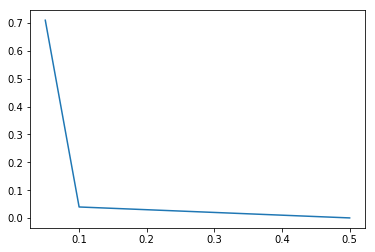

In [9]:
import time

times = []
for hi in hs:
    start = time.time()
    problem(hi)
    end = time.time()
    times.append(end - start)
print("Tiempos :", times)
plt.plot(hs, times)

5.	Modifique el programa para que el problema modelado posea sólo condiciones Dirichlet:
    1. Borde superior: 10
    2. Borde inferior: 5
    3. Borde derecho: 0
    4. Borde izquierdo: $f(y)=\sin(\pi\cdot y/H)$
    5. Y se mide desde la esquina inferior izquierda hacia arriba.
    
> Presente su solución utilizando h=0.1

_Para esta pregunta se deben reemplazar todas las condiciones de Dirichlet con las mencionadas en el enunciado, para E) en vez de usar la constante, se debe llamar a una función evaluada en la altura del punto_

6.	Modifique el programa de ejemplo para que modele la ecuación de Poisson utilizando $f(x,y) = \cos(x)\cdot\sin(y)$

_Ahora las ecuaciones deben ser de la forma: (en el interior, para los bordes es similar)_
$$U_{i-1, j} + U_{i+1, j} + U_{i, j-1} + U_{i, j+1} - 4\cdot U_{i, j} = h^2 f_{i, j}$$

7.	Volviendo al programa de ejemplo, modifíquelo para que los espaciados horizontal y vertical sean diferentes. Es decir, su programa debe utilizar un hx y un hy.

8.	¿Como cambian sus ecuaciones si el borde izquierdo también posee una condición de Neumann?. Implemente este caso, considerando que el borde izquierdo cumple con la siguiente condición de borde:

$$F(y) = \sin\left( 2 \pi \cdot \frac{x}{H}\right)$$


9.	Modifique el programa de ejemplo para que el dominio representado sea una L con condiciones de borde exclusivamente Dirichlet. Para esto:
    1. Será necesario calcular correctamente la cantidad de incógnitas.
    2. Reservar memoria para la matriz de coeficientes A y el vector del lado derecho b
    3. Generar una indexación del dominio. Esto es, asociar a cada i,j del interior del dominio un índice k. Esto se logra modificando convenientemente las funciones getIJ y getK.
    4. Una forma simple de abordar este problema es ir construyendo una tabla a medida que se recorre el dominio. Esta tabla debe almacenar el valor de i y j en cada fila k. De esta forma, dado un k, encontramos los i y j asociados. Y por otro lado, una búsqueda simple le permitirá encontrar la  k dados un i y j.
    5. Para generar los gráficos 2D, necesitara asignar un valor a puntos que se encuentran fuera del dominio. Para evitar que matplotlib los grafique, puede utilizar el valor NaN (Not a Number).

##### Si usted realizó exitosamente todas las actividades anteriores: ¡Felicitaciones!, ¡es un experto en diferencias finitas!.

In [6]:
HTML('<center><img src="https://media.giphy.com/media/3o8doT9BL7dgtolp7O/giphy.gif"></center>')


Hints:
-	matplotlib.pyplot.spy permite visualizar rápidamente el contenido de una matriz esparsa
